# Multi-TS Forecast

In [1]:
import os
os.chdir(os.environ['PWD'])

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('colorblind')
from conf import settings as sts
from conf import utils as uts
import re
import string
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm

#### Import Historical Data

In [3]:
dataset_filtered = pd.read_csv(sts.LOCAL_DATA_PATH+"final_prices_dataset_filtered.csv")

In [4]:
dataset_filtered

,date,group,product,market,mean_price
0,2013-01-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,790.0
1,2013-02-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,638.0
2,2013-03-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,705.0
3,2013-04-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,518.0
4,2013-05-01,verduras y hortalizas,pepino cohombro,cucuta cenabastos,550.0
...,...,...,...,...,...
406023,2022-07-01,frutas,limon mandarino,armenia retiro,1800.0
406024,2022-08-01,frutas,limon mandarino,armenia retiro,1887.0
406025,2022-09-01,frutas,limon mandarino,armenia retiro,2654.0
406026,2022-10-01,frutas,limon mandarino,armenia retiro,2303.0


In [5]:
dataset_filtered['date'] = pd.to_datetime(dataset_filtered['date'])

## Time Series Forecasting

In [6]:
date_range = pd.date_range(
    start = dataset_filtered['date'].min(), 
    end = dataset_filtered['date'].max(), 
    freq = 'MS'
)

In [7]:
dataset_filtered.shape[0] / date_range.shape[0]

3412.0

In [8]:
dataset_filtered['group'].nunique(), dataset_filtered['product'].nunique(), dataset_filtered['market'].nunique()

(8, 319, 72)

In [9]:
dataset_filtered['series_id'] = dataset_filtered.groupby(['group', 'product', 'market']).ngroup()

In [10]:
get_date_range = lambda start: pd.date_range(start = start, end = dataset_filtered['date'].max(), freq = 'MS')

In [30]:
dataset_filtered_f = dataset_filtered[dataset_filtered.series_id < 100]

In [104]:
multi_X_2 = []
multi_X_fore_2 = []
multi_y_2 = []
series_id_series = []

multi_y_pred_1 = []

In [105]:
predictions = {}

In [106]:
for series_id, series_df in tqdm(dataset_filtered_f.groupby('series_id')):
    series_df.set_index('date', inplace=True)
    group = series_df['group'].unique()[0]
    y = series_df['mean_price']
    date_range_idx = get_date_range(y.first_valid_index())
    y = y.reindex(date_range_idx).interpolate()
    
    X_1, X_fore_1 = uts.get_X_det(y, forecast_steps = 1)
    model_1, y_pred_1, residuals = uts.get_model(y, X_1, LinearRegression(), return_residuals = True)
    
    pred = {
        'index':X_fore_1.index[0],
        'point_det':model_1.predict(X_fore_1)[0]
    }
    predictions[series_id] = pred
    
    y_2, X_fore_2, X_2 = uts.get_X_res(residuals, 3)
    X_2['group'] = group
    X_fore_2['group'] = group
    
    y_pred_frame_1 = y_pred_1.iloc[3:].to_frame()
    y_pred_frame_1['series_id'] = series_id
    y_pred_frame_1['y_true'] = y.iloc[3:]
    
    multi_y_pred_1.append(y_pred_frame_1)
    multi_X_2.append(X_2)
    multi_X_fore_2.append(X_fore_2)
    multi_y_2.append(y_2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 93.28it/s]


In [107]:
multi_X_2 = pd.concat(multi_X_2)
multi_X_fore_2 = pd.concat(multi_X_fore_2)
multi_y_2 = pd.concat(multi_y_2)

multi_y_pred_1 = pd.concat(multi_y_pred_1)

In [108]:
predictions[0]

{'index': Timestamp('2022-12-01 00:00:00', freq='MS'),
 'point_det': 11930.812924899705}

In [109]:
feature_pipeline = ColumnTransformer(
    transformers=[
        ('group_onehot', OneHotEncoder(handle_unknown='ignore'), ['group']),
        ('numeric', 'passthrough', ['y_lag_1', 'y_lag_2', 'y_lag_3', 'y_rolling_std'])
    ],
)

In [110]:
feature_pipeline.fit(multi_X_2)

ColumnTransformer(transformers=[('group_onehot',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['group']),
                                ('numeric', 'passthrough',
                                 ['y_lag_1', 'y_lag_2', 'y_lag_3',
                                  'y_rolling_std'])])

In [111]:
trans_multi_X_2 = feature_pipeline.transform(multi_X_2)

In [112]:
model_2, multi_y_pred_2 = uts.get_model(multi_y_2, trans_multi_X_2, KNeighborsRegressor(), return_residuals=False)

In [113]:
multi_y_pred_1.shape

(11015, 3)

In [114]:
multi_y_pred_2.shape

(11015,)

In [117]:
multi_y_pred_1['y_pred'] = multi_y_pred_2 + multi_y_pred_1[0]

In [119]:
multi_y_pred_1['residuals'] = multi_y_pred_1['y_true'] - multi_y_pred_1['y_pred']

In [124]:
std_preds = multi_y_pred_1.groupby(['series_id'])['residuals'].std().to_dict()

In [132]:
point_res = pd.Series(model_2.predict(feature_pipeline.transform(multi_X_fore_2)), index = np.arange(multi_X_fore_2.shape[0])).to_dict()

In [151]:
final_predictions = {
    series_id:{
        'point_res': point_res[series_id],
        **predictions[series_id],
        'std': std_preds[series_id],
        'point': predictions[series_id]['point_det'] + point_res[series_id],
        'lower': predictions[series_id]['point_det'] + point_res[series_id] - std_preds[series_id],
        'upper': predictions[series_id]['point_det'] + point_res[series_id] + std_preds[series_id]
    }
    for series_id in np.arange(10)
}

In [153]:
final_predictions[0]

{'point_res': 817.2002369559035,
 'index': Timestamp('2022-12-01 00:00:00', freq='MS'),
 'point_det': 11930.812924899705,
 'std': 303.02936604463724,
 'point': 12748.013161855608,
 'lower': 12444.983795810971,
 'upper': 13051.042527900245}

In [155]:
series_df = dataset_filtered_f[dataset_filtered_f.series_id==0]
series_df.set_index('date', inplace=True)
group = series_df['group'].unique()[0]
y = series_df['mean_price']
date_range_idx = get_date_range(y.first_valid_index())
y = y.reindex(date_range_idx).interpolate()

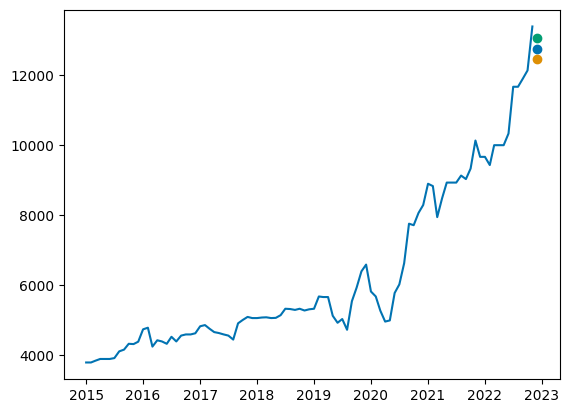

In [169]:
plt.plot(y)
plt.scatter(x = final_predictions[0]['index'], y = final_predictions[0]['point'])
plt.scatter(x = final_predictions[0]['index'], y = final_predictions[0]['lower'])
plt.scatter(x = final_predictions[0]['index'], y = final_predictions[0]['upper'])
plt.show()

In [166]:
final_predictions[0]['index']

Timestamp('2022-12-01 00:00:00', freq='MS')

In [167]:
y

2015-01-01     3800.0
2015-02-01     3800.0
2015-03-01     3850.0
2015-04-01     3900.0
2015-05-01     3900.0
               ...   
2022-07-01    11667.0
2022-08-01    11667.0
2022-09-01    11900.0
2022-10-01    12133.0
2022-11-01    13387.0
Freq: MS, Name: mean_price, Length: 95, dtype: float64